In [12]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames

In [13]:
path = Path.home() / 'Desktop' / 'disk2' / 'grand_average_lfps'

# 1) Parsing filenames of averaged LFPs

In [14]:
parsed_df = parse_filenames(path)
parsed_df.head()

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,797828357,VISp,toWhite,True,9,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
4,797828357,VISp,toWhite,False,66,1046.0,sessionID_797828357_area_VISp_condition_toWhit...


In [15]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [16]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

In [17]:
for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 19
('VISpm', 'toBlack', True) 19
('VISpm', 'toWhite', False) 19
('VISpm', 'toBlack', False) 19
('VISp', 'toWhite', True) 19
('VISp', 'toBlack', True) 19
('VISp', 'toWhite', False) 19
('VISp', 'toBlack', False) 19


# 2) Calculating weighted average

In [18]:
weighted_average_lfps = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    collected_lfp_arrs = []
    for cols in selected_df.iterrows():
        t, lfp_arr = np.load(path / cols[1].filename)
        # collected_lfp_arrs.append(lfp_arr * cols[1].flashesAveragedOver) # multiplied by weightings
        # collected_lfp_arrs.append(lfp_arr)
        for i in range(cols[1].flashesAveragedOver):
            collected_lfp_arrs.append(lfp_arr)
    weighted_average_lfps.append(np.array(collected_lfp_arrs).mean(axis=0))

In [19]:
selected_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
20,756029989,VISp,toBlack,False,46,990.0,sessionID_756029989_area_VISp_condition_toBlac...
34,778998620,VISp,toBlack,False,59,946.0,sessionID_778998620_area_VISp_condition_toBlac...
43,821695405,VISp,toBlack,False,74,NaN,sessionID_821695405_area_VISp_condition_toBlac...
51,715093703,VISp,toBlack,False,21,NaN,sessionID_715093703_area_VISp_condition_toBlac...
52,737581020,VISp,toBlack,False,44,NaN,sessionID_737581020_area_VISp_condition_toBlac...
53,797828357,VISp,toBlack,False,64,1046.0,sessionID_797828357_area_VISp_condition_toBlac...
62,754312389,VISp,toBlack,False,69,1126.0,sessionID_754312389_area_VISp_condition_toBlac...
66,758798717,VISp,toBlack,False,24,1266.0,sessionID_758798717_area_VISp_condition_toBlac...
68,778240327,VISp,toBlack,False,68,904.0,sessionID_778240327_area_VISp_condition_toBlac...
89,791319847,VISp,toBlack,False,52,902.0,sessionID_791319847_area_VISp_condition_toBlac...


In [20]:
# plt.plot(t,lfp_arr)
# plt.plot(t,lfp_arr*cols[1].flashesAveragedOver)

# plt.plot(t,np.array([lfp_arr, lfp_arr*cols[1].flashesAveragedOver]).mean(axis=0))
# plt.legend(['original', 'weighted by presentations', 'mean between both'])
# plt.show()

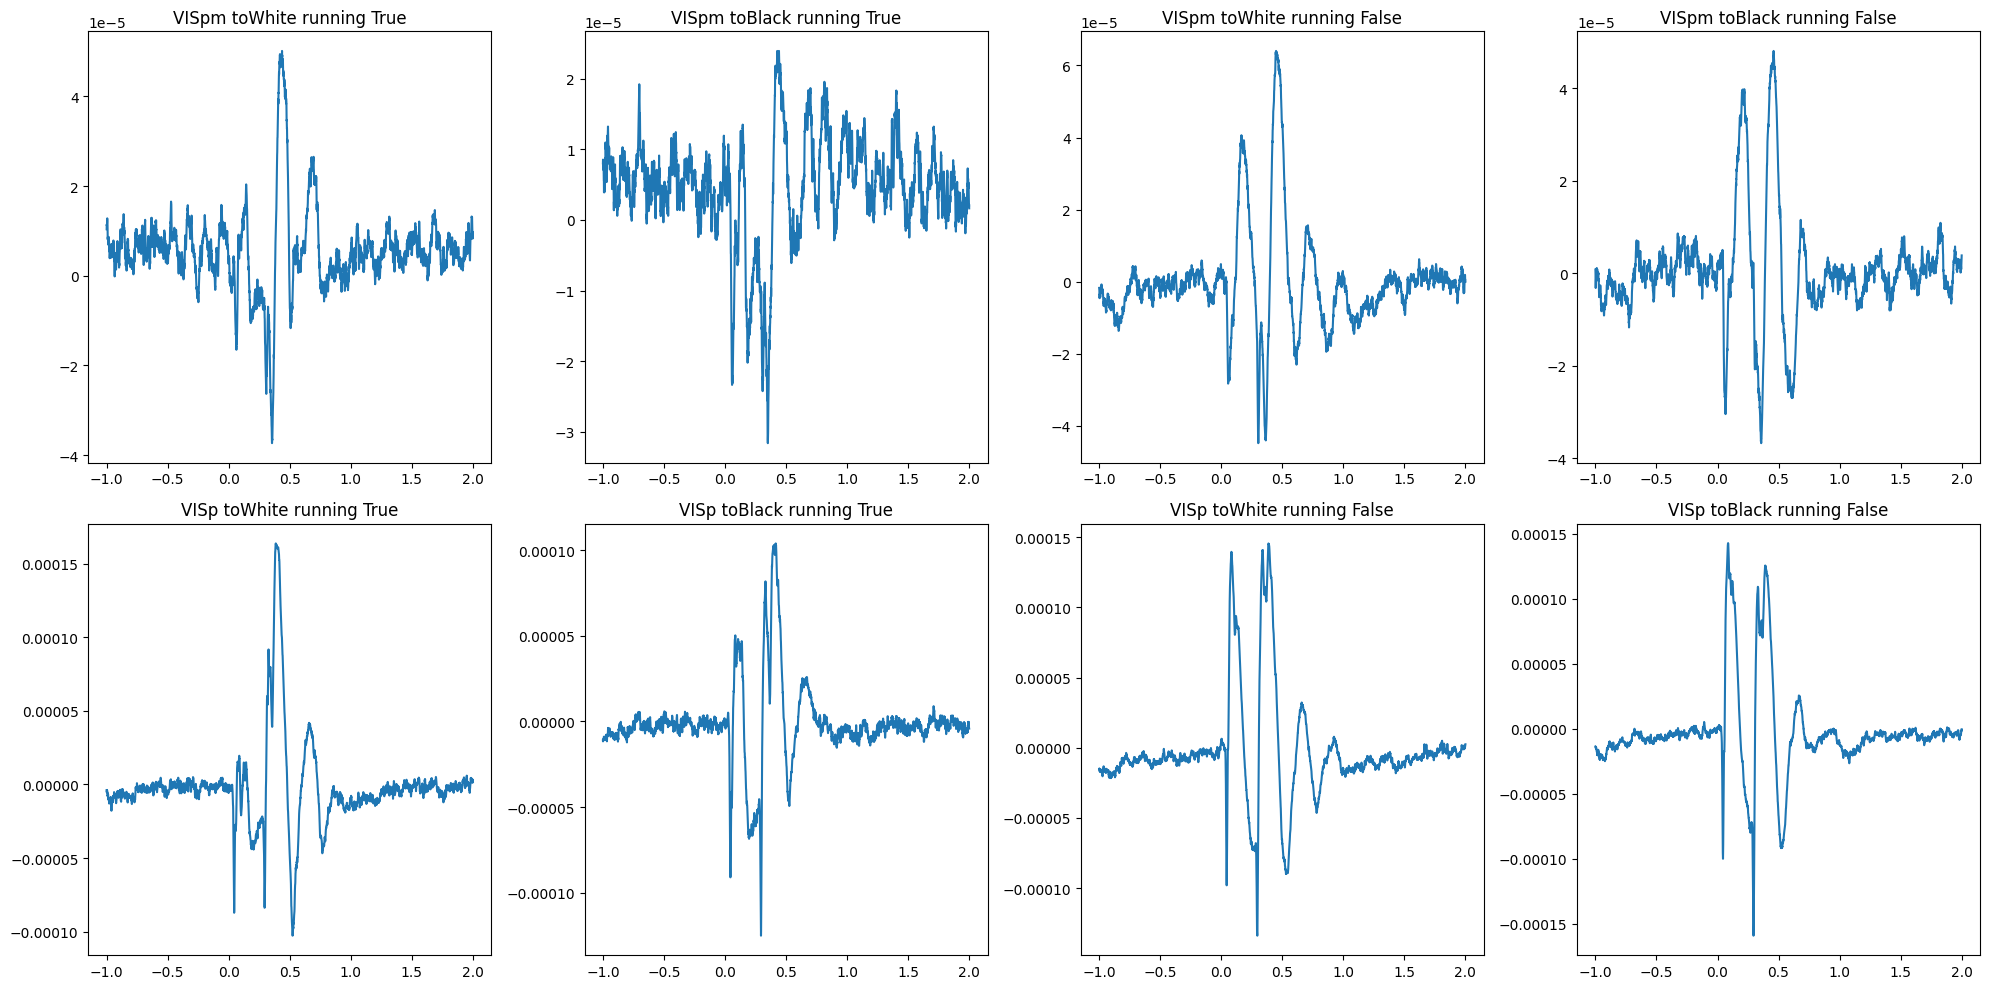

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

for i in range(4):
    ax[0][i].plot(t,weighted_average_lfps[i])
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    
for i in range(4):
    ax[1][i].plot(t,weighted_average_lfps[4+i])
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    
plt.tight_layout()
plt.show()